In [16]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
from agent import robot_on_gridworld
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
seed=42
np.random.seed(seed)
random.seed(seed)

In [18]:
ROBOT = robot_on_gridworld(
    water=[7, 19, 23],
    obstacles=[13, 18], 
    start_state=1 
    )
'🤖'

'🤖'

In [19]:
print(ROBOT._coord_to_state(3,2))  # should return 1
print(ROBOT._forbidden_coordinate(3,2))

18
True


In [20]:
def run_episode(policy, max_steps=2000):
    s = ROBOT.reset()
    G = 0.0
    ac_discount = 1.0 
    
    for _ in range(max_steps):
        a = policy(ROBOT, s)
        s, r, done = ROBOT.transition(a)
        G += ac_discount * r
        ac_discount *= ROBOT.gamma
        if done:
            break
    return G

#### 1. Uniformly random policy

In [21]:
def random_uniform_policy_ins(agent, state):
    return random.choice(agent.actions)

num_episodes = 10000
returns = np.empty(num_episodes, dtype=float)

for i in range(num_episodes):
    returns[i] = run_episode(random_uniform_policy_ins)

print(f"Episodes: {num_episodes}")
print(f"Discounted return stats:")
print(f"  mean = {np.mean(returns):.4f}")
print(f"  std  = {np.std(returns, ddof=0) :.4f}")
print(f"  min  = {np.min(returns):.4f}")
print(f"  max  = {np.max(returns):.4f}")

Episodes: 10000
Discounted return stats:
  mean = -9.1306
  std  = 7.1794
  min  = -45.9719
  max  = 3.4868


#### 2. Optimal policy
We have defined the transition rule in agent.py. Since the probability distribution is actually internal and unknown, we use Monte Carlo method to find the optimal policy. Also since we do not know the model, we should estimate action value rather than state value. We use Monte Carlo with Exploring Starts here.

In [22]:
def start_states():
    """Return list of valid start states (not goal or obstacles)."""
    blocked = ROBOT.obstacles
    return [s for s in range(1, ROBOT.n_states + 1)
            if s != ROBOT.goal_state and s not in blocked]

def greedy_action(Q, s):
    """Return greedy action index at state s from table."""
    return np.argmax(Q[s, :])

def mces_eposide(current_policy, s0, a0, max_steps=2000):
    """
    Generate one episode with exploring start (s0, a0)
    Returns (states, actions, rewards) trajectory 
    """
    states, actions, rewards = [], [], []
    saved = ROBOT.s
    ROBOT.s = s0

    s = s0
    a_idx = a0
    a = ROBOT.actions[a_idx]

    for _ in range(max_steps):
        s_next, r, done = ROBOT.transition(a)
        states.append(s)
        actions.append(a_idx)
        rewards.append(r)

        if done:
            break

        s = s_next
        a_idx = current_policy[s]
        a = ROBOT.actions[a_idx]
    ROBOT.s = saved
    return states, actions, rewards


In [23]:
def mces_control(num_episodes, max_steps=2000):
    """
    Monte Carlo Control with Exploring Starts (first-visit).
    Returns Q, current_policy (action indices)
    """

    nS, nA = ROBOT.n_states, len(ROBOT.actions)
    Q = np.zeros((nS+1, nA), dtype=float)   
    N = np.zeros((nS+1, nA), dtype=int)

    # deterministic initial policy (random choices per state)
    current_policy = np.zeros(nS+1, dtype=int)
    for s in range(1, nS + 1):
        current_policy[s] = 3 if s == ROBOT.goal_state else np.random.randint(0, nA)

    starts = start_states()

    for _ in range(num_episodes):
        # exploring start: uniformly random valid state and random action
        s0 = random.choice(starts)
        a0 = random.randrange(nA)

        states, actions, rewards = mces_eposide(current_policy, s0, a0, max_steps=max_steps)

        # first-visit MC returns
        G = 0.0
        visited = set()
        for t in range(len(states) - 1, -1, -1):
            s_t, a_t, r_tp1 = states[t], actions[t], rewards[t]
            G = r_tp1 + ROBOT.gamma * G
            if (s_t, a_t) in visited:
                continue
            visited.add((s_t, a_t))

            N[s_t, a_t] += 1
            Q[s_t, a_t] += (G - Q[s_t, a_t]) / N[s_t, a_t]

            # policy improvement
            current_policy[s_t] = greedy_action(Q, s_t)

    return Q, current_policy

In [24]:
Q, optimal_policy = mces_control(num_episodes=100_000, max_steps=2000)

V = np.zeros(ROBOT.n_states + 1, dtype=float)
for s in range(1, ROBOT.n_states + 1):
    V[s] = np.max(Q[s, :])

V_grid = V[1:].reshape(ROBOT.rows, ROBOT.cols)
with np.printoptions(precision=3, suppress=True):
    print("Estimated V* :")
    print(V_grid, "\n")

Estimated V* :
[[3.029 4.143 4.732 5.433 6.135]
 [2.072 3.698 5.2   6.118 7.048]
 [1.716 0.887 0.    6.398 8.104]
 [1.154 1.008 0.    8.733 9.955]
 [0.501 0.485 4.138 9.242 0.   ]] 



In [25]:
ARROWS = {'U': '↑', 'D': '↓', 'L': '←', 'R': '→'}
def show_policy(current_policy):
    """Pretty print of the learned policy as arrows."""
    rows = []
    for r in range(ROBOT.rows):
        row_syms = []
        for c in range(ROBOT.cols):
            s = ROBOT._coord_to_state(r, c)
            if s == ROBOT.goal_state:
                row_syms.append('G')
            elif s in (ROBOT.obstacles or []):
                row_syms.append('X')
            # elif s in (ROBOT.water or []):
            #     row_syms.append('W')
            else:
                a = ROBOT.actions[current_policy[s]]
                row_syms.append(ARROWS.get(a, '.'))
        rows.append(' '.join(row_syms))
    print('\n'.join(rows), '\n')

print("Optimal policy (arrows):")
show_policy(optimal_policy)

Optimal policy (arrows):
→ → → → ↓
↑ ↑ → → ↓
↑ ← X → ↓
→ ← X → ↓
→ ← ↑ → G 



In [26]:
print(ROBOT.s)

25


In [27]:
print(Q)

[[  0.           0.           0.           0.        ]
 [  1.69098867   1.86687273   2.58234823   3.02924141]
 [  2.06611463  -6.39891764   2.03626587   4.14268489]
 [  2.50069561   4.36917232   3.28994159   4.73183455]
 [  3.00240078   5.2140859    4.32688935   5.43278201]
 [  3.30597857   6.1346828    4.80638057   5.21228898]
 [  2.07165744   0.92307202   1.7169812   -6.22682209]
 [  3.69837044  -0.067374     0.83794378   2.98829942]
 [  3.53693594   3.91460997  -5.26210287   5.19959533]
 [  4.0778791    5.42358733   4.66660088   6.11757484]
 [  5.00167633   7.04843917   5.52719507   5.94904289]
 [  1.71566011   0.41769987   1.47302356   0.75320277]
 [ -6.4258806    0.35225813   0.88735872   0.25204592]
 [  0.           0.           0.           0.        ]
 [  5.40888221  -2.14982321   5.03674014   6.39829353]
 [  5.89445041   8.10389555   5.66818205   6.99951857]
 [  0.93422028   0.10244015   0.29479546   1.15423747]
 [  0.61782721   0.13105177   1.00761657   0.23994797]
 [  0.    

From the table of action value, we do not find any two (or more) actions share with the same optimal value, so the optimal policy is unique.

#### 3. Implementation of the optimal policy

In [28]:
def optimal_policy_ins(agent, s):
    return agent.actions[optimal_policy[s]]

num_eval = 10_000
returns = np.empty(num_eval, dtype=float)
for i in range(num_eval):
    returns[i] = run_episode(optimal_policy_ins)

print(f"Episodes: {num_eval}")
print(f"Mean = {np.mean(returns):.4f}")
print(f"Std  = {np.std(returns, ddof=0):.4f}")
print(f"Min  = {np.min(returns):.4f}")
print(f"Max  = {np.max(returns):.4f}")

Episodes: 10000
Mean = 2.9877
Std  = 3.0207
Min  = -24.8247
Max  = 4.7830


#### 4. CDF and quantile

[INFO] Random seed used for all experiments: 42


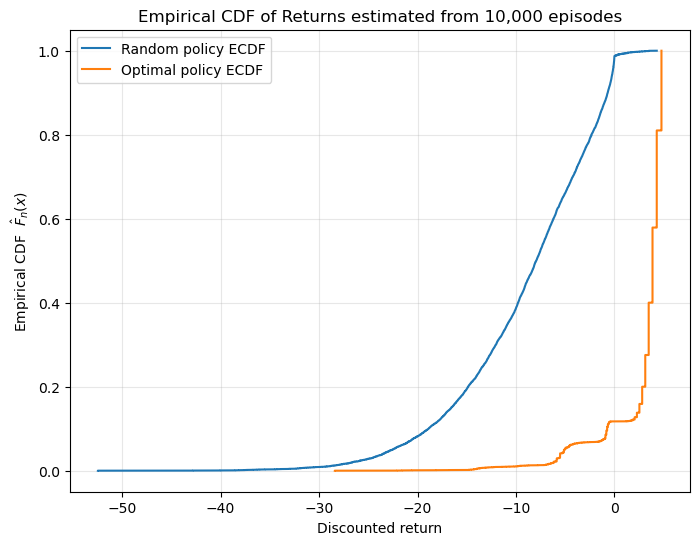

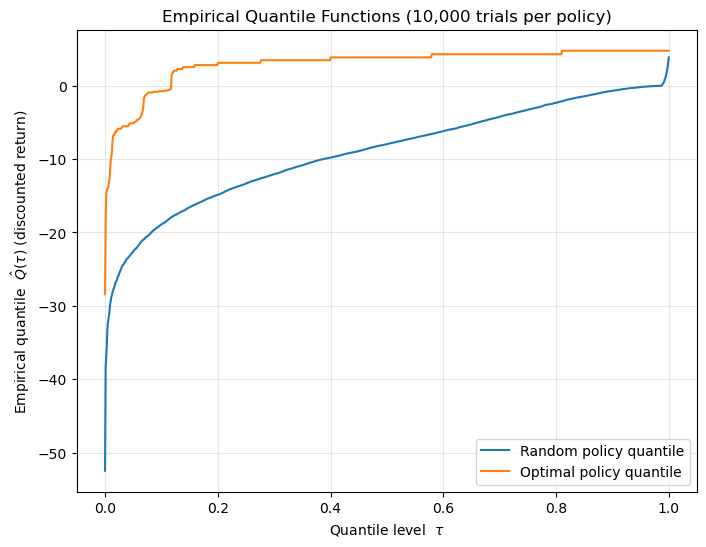

In [29]:
def collect_returns(policy_ins, n_eposide=10_000):
    returns = np.empty(n_eposide, dtype=float)
    for i in range(n_eposide):
        returns[i] = run_episode(policy_ins)
    return returns

def e_cdf(sorted_samples):
    n = sorted_samples.size
    # Evenly spaced CDF values
    y = np.arange(1, n + 1, dtype=float) / n
    return sorted_samples, y

def e_quantile(sorted_samples, taus):
    # Q_hat(tau) = Z_{ floor((n+1) * tau) }, with Z_0 := Z_1
    n = sorted_samples.size
    idx = np.floor((n + 1) * taus).astype(int)
    idx = np.clip(idx, 1, n) - 1  # to 0-based indices
    return sorted_samples[idx]

R_random = collect_returns(random_uniform_policy_ins, n_eposide=10_000)
R_optimal = collect_returns(optimal_policy_ins, n_eposide=10_000)

# sort for ECDF / quantile
Z_random = np.sort(R_random)
Z_optimal = np.sort(R_optimal)

print(f"[INFO] Random seed used for all experiments: {seed}")

xr, yr = e_cdf(Z_random)
xo, yo = e_cdf(Z_optimal)
plt.figure(figsize=(8, 6))
plt.step(xr, yr, label='Random policy ECDF')
plt.step(xo, yo, label='Optimal policy ECDF')
plt.xlabel('Discounted return')
plt.ylabel('Empirical CDF  $\hat{F}_n(x)$')
plt.title('Empirical CDF of Returns estimated from 10,000 episodes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

taus = np.linspace(0.0 + 1e-4, 1.0 - 1e-4, 1000)  
q_random = e_quantile(Z_random, taus)
q_opt    = e_quantile(Z_optimal, taus)

plt.figure(figsize=(8, 6))
plt.plot(taus, q_random, label='Random policy quantile')
plt.plot(taus, q_opt, label='Optimal policy quantile')
plt.xlabel('Quantile level  $\\tau$')
plt.ylabel('Empirical quantile  $\\hat{Q}(\\tau)$ (discounted return)')
plt.title('Empirical Quantile Functions (10,000 trials per policy)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 5. Probability estimation
Since the environment is a MDP process, we can set the initial state to be in 18 (state 20 in my convention), and evaluate the conditional probability using fewer steps.

In [30]:
def estimate_from_20(trials=200_000):
    hits, total = 0, 0
    for _ in range(trials):
        # set initial state to 20
        ROBOT.s = 20

        s = 20
        done = False
        # roll exactly 11 steps (from t=8 to t=19)
        for _ in range(11):
            a = random_uniform_policy_ins(ROBOT, s)
            s, r, done = ROBOT.transition(a)
            if done:
                # absorb at goal, can't reach state 23
                break

        if s == 23:
            hits += 1
        total += 1

    p_hat = hits / total
    return p_hat

p = estimate_from_20(200_000)
print(f"P(S19=21 | S8=18) ≈ {p:.6f}")

P(S19=21 | S8=18) ≈ 0.018725
